0.5663409708295999


C:\Users\Alexa\AppData\Local\Temp\ipykernel_8144\2194836950.py:95: RuntimeWarning: invalid value encountered in log
  Y = np.log(expY)


-65039.502501768344
0.000237096323153011


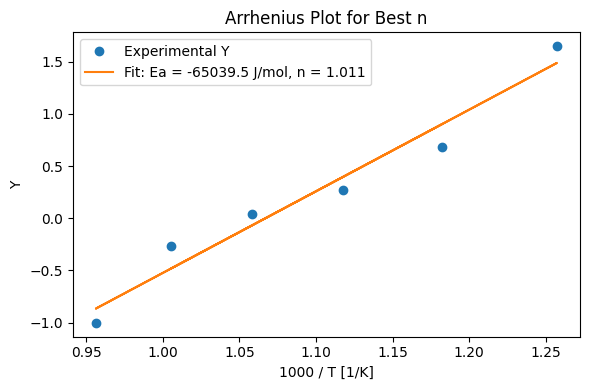

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

'''I assume that the entire SMR reaction happens instantly and then we do WGS after. Not the most accurate prob. 
We could integrate along the reaction (setting up a dPCH4 and using that to solve through dPCO2) 

THIS IS INCORRECT I NEED TO ADJUST THE PARTIAL PRESSURES DURING INITIALLIZATION LIKE IN THE INTEGRATION

do it till CO2 is matching its most outer thing

If we ever want to be more accurate we have to adjust the accuracy of our outlet partial pressures
'''

# === INPUT DATA ===
dP_CO = 0.0001
Ptot = 1 # bar

T_data = np.array([845.79, 945.17, 1045.52, 795.41, 894.75, 994.56])  # Temperature in K

#inlet SCCM
SCCM_CH4_feed = 16.16
SCCM_H2_feed = 10
SCCM_CO_feed = 0
SCCM_CO2_feed = 0
SCCM_H20_feed = 48.48
SCCM_Ar_feed = 5

#before WGS
SCCM_CH4_in_data = np.array([10.20, 4.40, 1.48, 13.09, 7.51, 2.05])
dCH4 = SCCM_CH4_feed - SCCM_CH4_in_data
SCCM_H2_in_data = SCCM_H2_feed + 3*dCH4
SCCM_CO_in_data = dCH4
SCCM_CO2_in = 0
SCCM_H2O_in_data = SCCM_H20_feed - dCH4

TotalSCCM = SCCM_CH4_in_data + SCCM_H2_in_data + SCCM_CO_in_data + SCCM_H2O_in_data + SCCM_CO2_in + 5

P_CH4_in_data = Ptot * SCCM_CH4_in_data/TotalSCCM
P_H2_in_data = Ptot * SCCM_H2_in_data/TotalSCCM
P_CO_in_data = Ptot * SCCM_CO_in_data/TotalSCCM
P_CO2_in = 0
P_H2O_in_data = Ptot * SCCM_H2O_in_data/TotalSCCM
P_Ar_in_data = Ptot * 5/TotalSCCM

# P_CO_out_Data = np.array([0.022676, 0.06384, 0.10341, 0.010517, 0.04366, 0.090570]) #bar
P_CO2_out_Data = np.array([0.043676, 0.041360, 0.020221, 0.0344865, 0.043659, 0.034350])

V_R = 2343.7 * 10**-9  # Reactor volume in m^3
total_flow = (16.16 + 10 + 48.48 + 5)/60000000 #m^3/s
S_V = total_flow/V_R  # 1/sec
print(S_V)
R = 8.314  # J/mol/K


# === EQUILIBRIUM CONSTANT FUNCTION ===
def K_eq(T):
    return np.exp(4400/T - 4.036)

# === INTEGRAL FUNCTION ===
def integral_I(n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in):
    sum = 0
    #adjust these to get the data when you are done
    P_CH4 = P_CH4_in
    P_CO2 = P_CO2_in
    P_H2O = P_H2O_in
    P_H2 = P_H2_in
    P_CO = P_CO_in
    P_Ar = P_Ar_in

    while P_CO2 < P_CO2_out:
        sum = sum + dP_CO/((P_CO**n) * (P_H2O**n) - 1/(K_eq(T)) * (P_CO2**n) * (P_H2**n))
        P_CO2 = P_CO2 + dP_CO
        P_H2O = P_H2O - dP_CO
        P_H2 = P_H2 + dP_CO
        P_CO = P_CO - dP_CO

        #pressure normalization 
        Ptotnew = P_CH4 + P_CO2 + P_H2O + P_H2 + P_CO + P_Ar
        P_CO2 = P_CO2*Ptot/Ptotnew
        P_H2O = P_H2O*Ptot/Ptotnew
        P_H2 = P_H2*Ptot/Ptotnew
        P_CO = P_CO*Ptot/Ptotnew
    return sum

# === SCAN n VALUES AND FIT ===
n_range = np.linspace(0.1, 1.05, 50)
results = []

for n in n_range:
    I_n = np.array([integral_I(n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in)
                    for T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in in 
                    zip(T_data, P_CO2_out_Data, P_H2O_in_data, P_CO_in_data, P_H2_in_data, P_CH4_in_data, P_Ar_in_data)])
    expY = (S_V * I_n)
    Y = np.log(expY)
    inv_T = 1 / T_data
    slope, intercept, r_value, _, _ = linregress(inv_T, Y)
    Ea = -slope * R
    results.append({
        'n': n,
        'Ea_Jmol': Ea,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    })

# === SELECT BEST n ===
best_result = max(results, key=lambda d: d['r_squared'])
best_n = best_result['n']
best_slope = best_result['slope']
best_intercept = best_result['intercept']
best_Ea = best_result['Ea_Jmol']
print(best_Ea)
print(np.exp(best_intercept))

# === PLOT BEST FIT ===
I_best = np.array([integral_I(best_n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in)
                    for T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in, P_CH4_in, P_Ar_in in 
                    zip(T_data, P_CO2_out_Data, P_H2O_in_data, P_CO_in_data, P_H2_in_data, P_CH4_in_data, P_Ar_in_data)])
expY_best = (S_V * I_best)
Y_best = np.log(expY_best)
inv_T = 1 / T_data
Y_fit = best_slope * inv_T + best_intercept

plt.figure(figsize=(6, 4))
plt.plot(inv_T*1000, Y_best, 'o', label='Experimental Y')
plt.plot(inv_T*1000, Y_fit, '-', label=f'Fit: Ea = {best_Ea:.1f} J/mol, n = {best_n:.3f}')
plt.xlabel('1000 / T [1/K]')
plt.ylabel('Y')
plt.title('Arrhenius Plot for Best n')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()